<a href="https://colab.research.google.com/github/aminejarraya/Deep-Learning-Image-Compression-/blob/main/Pre_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Download Necessary Packages

In [ ]:
#Install open slide Package
!apt update && apt install -y openslide-tools
!pip install openslide-python

Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Get:5 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:9 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Ign:12 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packages
Get:12 https://developer.downlo

In [ ]:
#Packages to Unzip rar file
!pip install pyunpack
!pip install patool

     |████████████████████████████████| 77 kB 4.2 MB/s 


In [ ]:
!pip install sewar

  Created wheel for sewar: filename=sewar-0.4.4-py3-none-any.whl size=10389 sha256=c375829fafeb90e2802411ad87a61a12d35e8dcd719260680dc35b38922cbfaa
  Stored in directory: /root/.cache/pip/wheels/b5/00/df/f1ba40d0d44c95b0db52804e518c128d5631866b91ea1960ba
Successfully built sewar


## Import packages

In [ ]:
import cv2
from google.colab import drive
import numpy as np
import tensorflow
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Input, LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from pyunpack import Archive
import openslide
from tqdm import tqdm
from google.colab.patches import cv2_imshow
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import Dropout
import os
import skimage.io as io
import skimage.transform as trans
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot
from sewar.full_ref import mse, uqi, ssim
from keras.optimizers import Adam, Adagrad, RMSprop, SGD
import pandas as pd

In [ ]:
import cv2
from google.colab import drive
import numpy as np
import tensorflow
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Input, LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from pyunpack import Archive
import openslide
from tqdm import tqdm
from google.colab.patches import cv2_imshow
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import Dropout
import os
import skimage.io as io
import skimage.transform as trans
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot
from sewar.full_ref import mse, uqi, ssim
from keras.optimizers import Adam, Adagrad, RMSprop, SGD
import pandas as pd

In [ ]:
#Mount Drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
#Extract zip file located in the drive into home
Archive('/content/drive/MyDrive/TCGA-A8-A08F-01A-01-TS1.e2b24767-1df7-431b-bba2-45d1b4e767d8.rar').extractall('./')

## Read svs/tif/tiff file

In [ ]:
slide = openslide.OpenSlide("TCGA.svs")
x = slide.read_region((8891,8131),0,(256,256))
x = np.array(x)
x = cv2.cvtColor(x, cv2.COLOR_BGRA2RGB)
x = (x.astype("float32"))/255.0
inputs = np.expand_dims(x, axis=0)

In [ ]:
#Model Builder
def build(width, height, depth):
		# initialize the input shape to be "channels last" along with
		# the channels dimension itself
  inputShape = (height, width, depth)
    # define the input to the encoder
  inputs = Input(shape=inputShape)
  x = inputs
  conv1 = Conv2D(64, (3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(x)
  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
  conv2 = Conv2D(128, (3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
  pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
  conv3 = Conv2D(256, (3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
  pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
  conv4 = Conv2D(512, (3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
  drop4 = Dropout(0.5)(conv4)
  pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)
  encoder = Conv2D(16, (3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
  drop5 = Dropout(0.5)(encoder)

  up7 = UpSampling2D(size = (2,2))(drop5)
  conv7 = Conv2D(512, (3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(up7)
  up8 = UpSampling2D(size = (2,2))(conv7)
  conv8 = Conv2D(256, (3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(up8)
  up8_8 = UpSampling2D(size = (2,2))(conv8)
  conv8_8 = Conv2D(128, (3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(up8_8)
  up9 = UpSampling2D(size = (2,2))(conv8_8)
  conv9 = Conv2D(64, (3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(up9)
  conv10 = Conv2D(32, (3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
  conv11 = Conv2D(32, (3,3), activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv10)
  decoder = Conv2D(3, (1,1), activation = 'sigmoid')(conv11)

  autoencoder = Model(x, decoder)
  return autoencoder

In [ ]:
autoencoder = build(256,256,3)

In [ ]:
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 256, 256, 64)      1792      
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 256, 256, 64)      0         
_________________________________________________________________
batch_normalization_11 (Batc (None, 256, 256, 64)      256       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 128, 128, 128)     73856     
_________________________________________________________________
leaky_re_lu_12 (LeakyReLU)   (None, 128, 128, 128)     0   

#Training

**We will be running into different optimizers using our architecture in order to know which optimizer is the best fit**

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


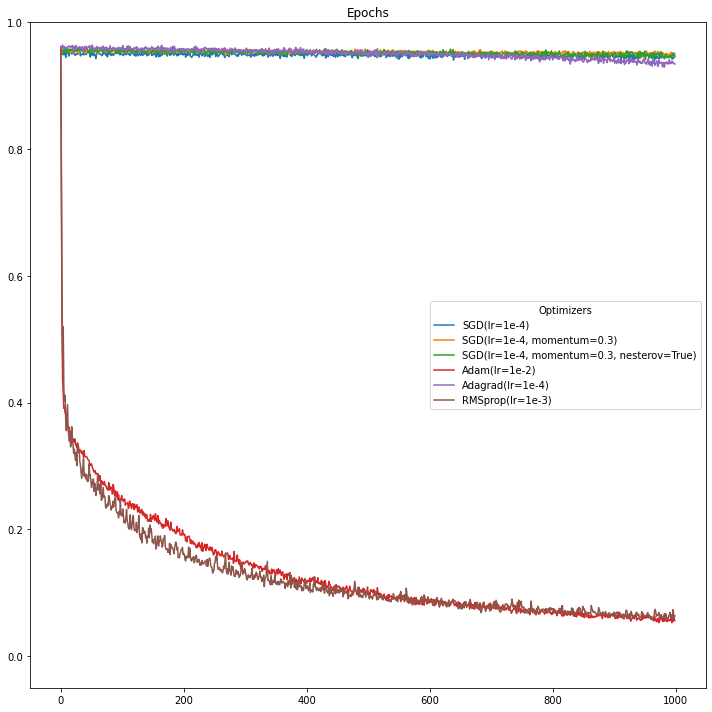

In [ ]:
dflist = []
optim = ['SGD(lr=1e-4)',
                 'SGD(lr=1e-4, momentum=0.3)',
                 'SGD(lr=1e-4, momentum=0.3, nesterov=True)',
                 'Adam(lr=1e-2)',
                 'Adagrad(lr=1e-4)',
                 'RMSprop(lr=1e-3)']
for opt_names in optim:
  K.clear_session()

  autoencoder = build(256,256,3)
  autoencoder.compile(loss=SSIMLoss, optimizer=eval(opt_names))
  h = autoencoder.fit(inputs, inputs, epochs=1000, verbose=0)

  dflist.append(pd.DataFrame(h.history, index=h.epoch))

historydf = pd.concat(dflist, axis=1)
metrics_reported = dflist[0].columns
idx = pd.MultiIndex.from_product([optim, metrics_reported],
                                 names=['Optimizers', 'metric'])
historydf.columns = idx

plt.figure(figsize=(10,10))
ax = plt.subplot(111)
historydf.xs('loss', axis=1, level='metric').plot(ylim=(-0.05,1), ax=ax)
plt.title("Loss")
plt.title("Epochs")

plt.tight_layout()

**After considering that Adam and RMSProp are the best one, we will be running into different learning rates**

**Adam optimizer**

In [ ]:
import tensorflow as tf

In [ ]:
def SSIMLoss(y_true, y_pred):
  return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0))

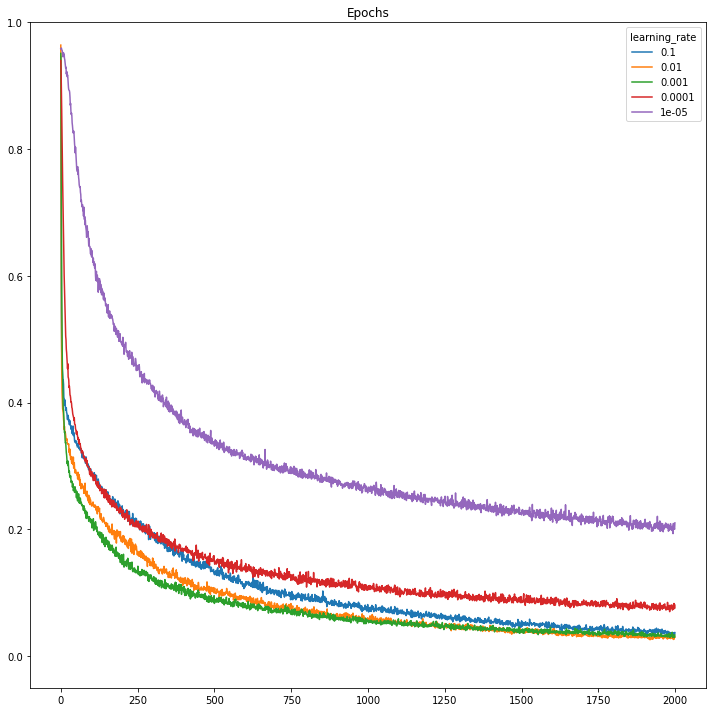

In [ ]:
dflist = []
learning_rate = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
for lr in learning_rate:
  K.clear_session()

  autoencoder = build(256,256,3)
  opt = tensorflow.keras.optimizers.Adam(learning_rate=lr)
  autoencoder.compile(loss=SSIMLoss, optimizer=opt)
  h = autoencoder.fit(inputs, inputs, epochs=2000, verbose=0)

  dflist.append(pd.DataFrame(h.history, index=h.epoch))

historydf = pd.concat(dflist, axis=1)
metrics_reported = dflist[0].columns
idx = pd.MultiIndex.from_product([learning_rate, metrics_reported],
                                 names=['learning_rate', 'metric'])
historydf.columns = idx

plt.figure(figsize=(10,10))
ax = plt.subplot(111)
historydf.xs('loss', axis=1, level='metric').plot(ylim=(-0.05,1), ax=ax)
plt.title("Loss")
plt.title("Epochs")

plt.tight_layout()

**RMSprop Optimizer**

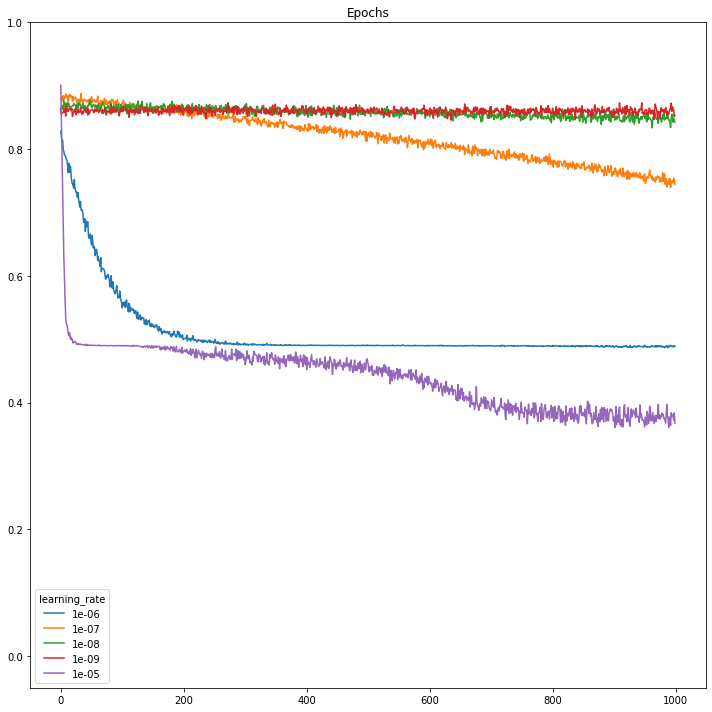

In [ ]:
from keras import backend as K
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
dflist = []
learning_rate = [1e-6, 1e-7, 1e-8, 1e-9, 1e-5]
for lr in learning_rate:
  K.clear_session()

  autoencoder = build(256,256,3)
  opt = tensorflow.keras.optimizers.RMSprop(learning_rate=lr)
  autoencoder.compile(loss=SSIMLoss, optimizer=opt)
  h = autoencoder.fit(inputs, inputs, epochs=1000, verbose=0)

  dflist.append(pd.DataFrame(h.history, index=h.epoch))

historydf = pd.concat(dflist, axis=1)
metrics_reported = dflist[0].columns
idx = pd.MultiIndex.from_product([learning_rate, metrics_reported],
                                 names=['learning_rate', 'metric'])
historydf.columns = idx

plt.figure(figsize=(10,10))
ax = plt.subplot(111)
historydf.xs('loss', axis=1, level='metric').plot(ylim=(-0.05,1), ax=ax)
plt.title("Loss")
plt.title("Epochs")

plt.tight_layout()

**Since 1e-4 is the best learning rate we will be using it for further testing in only one sample before running it through all the dataset**

In [ ]:
autoencoder = build(256,256,3)
#Compile it
opt = tensorflow.keras.optimizers.Adam(learning_rate=1e-2)
autoencoder.compile(loss=SSIMLoss, optimizer=opt)

history = autoencoder.fit(inputs, inputs, epochs=1500, verbose=1)

Epoch 1/1500
1/1 [==============================] - 3s 3s/step - loss: 0.7613
Epoch 2/1500
1/1 [==============================] - 0s 31ms/step - loss: 0.9398
Epoch 3/1500
1/1 [==============================] - 0s 30ms/step - loss: 0.7339
Epoch 4/1500
1/1 [==============================] - 0s 28ms/step - loss: 0.4841
Epoch 5/1500
1/1 [==============================] - 0s 28ms/step - loss: 0.4839
Epoch 6/1500
1/1 [==============================] - 0s 29ms/step - loss: 0.4821
Epoch 7/1500
1/1 [==============================] - 0s 30ms/step - loss: 0.4782
Epoch 8/1500
1/1 [==============================] - 0s 27ms/step - loss: 0.4681
Epoch 9/1500
1/1 [==============================] - 0s 29ms/step - loss: 0.4459
Epoch 10/1500
1/1 [==============================] - 0s 36ms/step - loss: 0.4470
Epoch 11/1500
1/1 [==============================] - 0s 30ms/step - loss: 0.4304
Epoch 12/1500
1/1 [==============================] - 0s 29ms/step - loss: 0.4306
Epoch 13/1500
1/1 [====================

KeyboardInterrupt: ignored

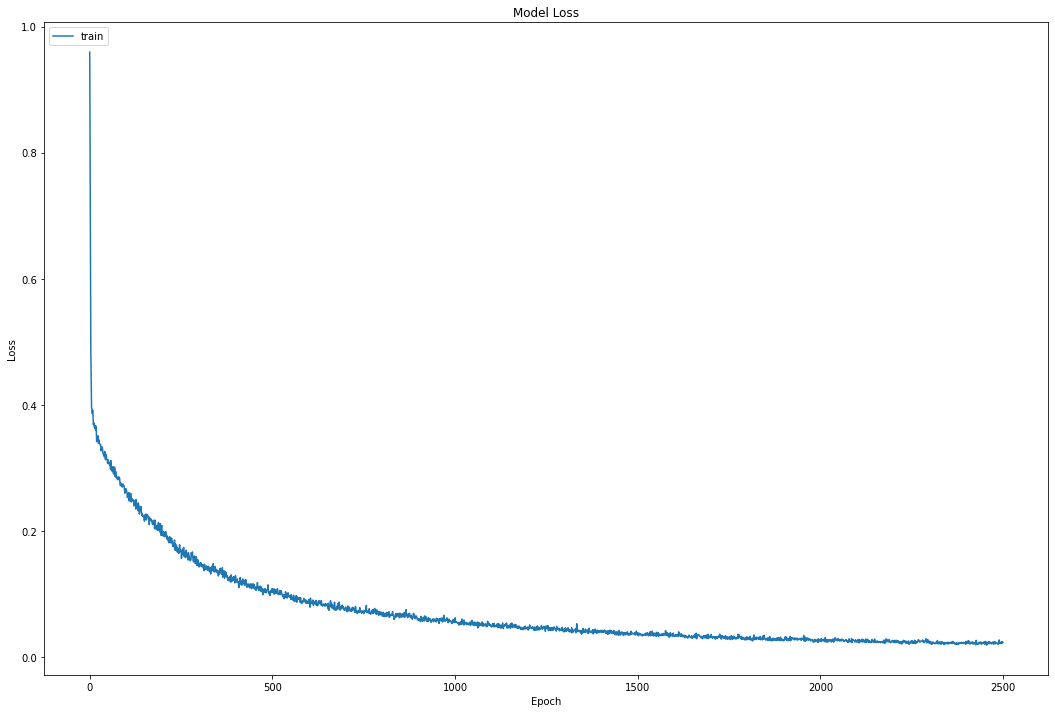

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(18, 12))
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train'], loc='upper left')
plt.show()


**Testing**

In [ ]:
x = slide.read_region((8891,8131),0,(256,256))
x = np.array(x)
img = cv2.cvtColor(x, cv2.COLOR_BGRA2RGB)
img = (img.astype("float32"))/255.0
img = np.expand_dims(img, axis=0)
decoder = autoencoder.predict(img)
dix = decoder.reshape((256,256,3))
img = img.reshape((256,256,3))
original = (img * 255).astype("uint8")
recon = (dix * 255).astype("uint8")
output = np.hstack([original, recon])

# Results

**Visual Results**

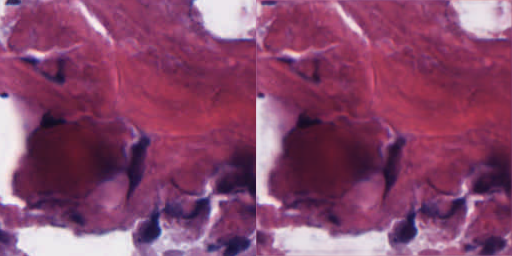

In [ ]:
cv2_imshow(output)

**Metric's results**

In [ ]:
print("Mean Squared Error = " + str(mse(original, recon)))
print("Universal Quality Index = " + str(uqi(original, recon)))
print("SSIM = " + str(ssim(original, recon)[0]))

Mean Squared Error = 98.50924682617188


In [ ]:
print("Universal Quality Index = " + str(uqi(original, recon)))

Universal Quality Index = 0.9956970828587476


In [ ]:
print("SSIM = " + str(ssim(original, recon)[0]))

SSIM = 0.9650034808461762
